In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from Preprocessing2 import Signal_process, Stat_process 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from icecream import ic 
from scipy import signal
import pickle
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling1D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D
from tensorflow.keras.layers import UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D, MaxPooling1D, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow import keras
from tensorflow.keras import callbacks as cb

tf.random.set_seed(121)

In [349]:
path = 'D:/Data/CMAPSSData'

train_path_list = sorted(glob(path + '/train*'))
test_path_list = sorted(glob(path + '/test*'))
rul_path_list = sorted(glob(path + '/RUL*'))

In [350]:
col_name = ['unit number', 'time', 'op1', 'op2', 'op3']
temp = ['sensor %d'%(i+1) for i in range(23)]

load_col_name = col_name + temp
col_name = load_col_name[:-2]

In [351]:
train = []
for t_path in train_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    train.append(temp[col_name])

test = []
for t_path in test_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    test.append(temp[col_name])
    
RUL = []
for r_path in rul_path_list:
    temp = pd.read_table(r_path, header = None, names = ['RUL'])
    RUL.append(temp)

In [352]:
train_index = []
for key, value in enumerate(train):
    train_index.append(train[key][['unit number', 'time']])
    train[key] = train[key].drop(['unit number', 'time'], axis = 1)
    
test_index = []
for key, value in enumerate(test):
    test_index.append(test[key][['unit number', 'time']])
    test[key] = test[key].drop(['unit number', 'time'], axis = 1)

In [353]:
unit_num_train = []
for D in train_index:
    unit_num_train.append(D.groupby('unit number').count().shape[0])

In [354]:
unit_num_test = []
for D in test_index:
    unit_num_test.append(D.groupby('unit number').count().shape[0])

In [355]:
label = []

for key, values in enumerate(unit_num_train):
    temp = []
    for i in range(values):
        index = train_index[key].groupby('unit number').get_group(i+1).index
        N = len(index)
        rul = np.linspace(0,1,N)
        temp.append(rul)
    temp = np.concatenate(temp)
    label.append(temp)

In [356]:
#SCALE = 'None' # MINMAX, STANDARD

def NORM(TRAIN, SCALE):
    if SCALE == 'MINMAX':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = MinMaxScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])

    if SCALE == 'STANDARD':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = StandardScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])
    
    return TRAIN

In [357]:
minmax_train = NORM(train, 'MINMAX')

train_ = pd.concat([train_index[0], minmax_train[0]], axis = 1)
variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
selected_col

['time',
 'op1',
 'op2',
 'sensor 2',
 'sensor 3',
 'sensor 4',
 'sensor 11',
 'sensor 15',
 'sensor 20',
 'sensor 21']

In [363]:
minmax_train[0] = minmax_train[0][selected_col[1:]]
minmax_train[1] = minmax_train[1][selected_col[1:]]
minmax_train[2] = minmax_train[2][selected_col[1:]]
minmax_train[3] = minmax_train[3][selected_col[1:]]

In [364]:
minmax_train[0]['RUL'] = label[0]
minmax_train[1]['RUL'] = label[1]
minmax_train[2]['RUL'] = label[2]
minmax_train[3]['RUL'] = label[3]

In [365]:
train_ratio = 0.8
train_indices = []
validation_indices = []

for i in range(4):
    D = list(set(train_index[i]['unit number']))
    N = len(D)
    ratio = int(train_ratio * N)
    indices = np.random.permutation(D)
    train_idx, val_idx = indices[:ratio], indices[ratio:]
    
    train_indices.append(train_idx)
    validation_indices.append(val_idx)

In [366]:
def rolling_window(a, window, axis=0):
    """
         Return the array of the 2D array sliding window array
    """
    if axis == 0:
        shape = (a.shape[0] - window +1, window, a.shape[-1])
        strides = (a.strides[0],) + a.strides
        a_rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    elif axis==1:
        shape = (a.shape[-1] - window +1,) + (a.shape[0], window) 
        strides = (a.strides[-1],) + a.strides
        a_rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_rolling

# Make Train & Validation Set

In [416]:
window_len = 20
X = []
INDEX = []
for key, values in enumerate(train_indices):
    temp = []
    for i in values:
        index = train_index[key].groupby('unit number').get_group(i).index
        INDEX.append(len(index))
        D = minmax_train[key].loc[index]
        win_gen = rolling_window(D.values, window_len)
        temp.append(win_gen)

    temp = np.concatenate(temp)
    X.append(temp)

In [388]:
window_len = 20
X_val = []
for key, values in enumerate(validation_indices):
    temp = []
    for i in values:
        index = train_index[key].groupby('unit number').get_group(i).index
        D = minmax_train[key].loc[index]
        win_gen = rolling_window(D.values, window_len)
        temp.append(win_gen)

    temp = np.concatenate(temp)
    X_val.append(temp)

In [390]:
X[0].shape
X_val[0].shape

(3503, 20, 10)

In [391]:
x_train = np.concatenate(X)[:,:,:-1].copy()
y_train = np.concatenate(X)[:,-1,-1].copy()

x_val = np.concatenate(X_val)[:,:,:-1].copy()
y_val = np.concatenate(X_val)[:,-1,-1].copy()

In [393]:
x_train.shape

(117315, 20, 9)

In [469]:
window_len = 20
X_test = []
INDEX_test = []
for key, values in enumerate(test):
    temp = []
    for i in range(unit_num_test[key]):
        index = test_index[key].groupby('unit number').get_group(i+1).index
        INDEX_test.append(len(index))
        D = test[key].loc[index]
        win_gen = rolling_window(D.values, window_len)
        temp.append(win_gen)

    temp = np.concatenate(temp)
    X_test.append(temp)

In [470]:
x_test = np.concatenate(X_test)[:,:,:-1].copy()
y_test = np.concatenate(X_test)[:,-1,-1].copy()

In [398]:
def FEAE():
    '''Autoencoder part'''   
       
    '''signal AE'''
    signal_inputs = Input(shape = (20, 9), name = 'signal_inputs')
    z = Conv1D(filters=8, kernel_size=10, padding='same', activation='tanh')(signal_inputs)
   #z = MaxPooling1D(5)(z)
    z = Conv1D(filters=4, kernel_size=5, padding='same', activation='tanh')(z)
    z = Conv1D(filters=1, kernel_size=5, padding='same', activation='tanh')(z)
    z = MaxPooling1D(5)(z)
    
    latent_z = Flatten(name = 'latent_z')(z)
    z = Reshape((4,1))(latent_z)
    
    z = Conv1DTranspose(filters = 1, kernel_size=5, strides=5, padding='same', activation='elu')(z)
    z = Conv1D(filters=4, kernel_size=5, padding='same', activation='tanh')(z)
    z = Conv1D(filters=8, kernel_size=10, padding='same', activation='tanh')(z)  
    z = Conv1D(filters=9, kernel_size=15, padding='same', name='signal_AE', activation='relu')(z) 
    
#     '''RUL part'''
#     latent_stat = Dense(6, activation='tanh')(latent_x) 
    latent_signal = Dense(3, activation='tanh')(latent_z)    
    #latent_fft = Dense(4, activation='tanh')(latent_z)

#     concat = concatenate([latent_stat, latent_signal, latent_fft])
    #h = Dense(4, activation='tanh')(latent_fft)
    h = Dense(1, activation='tanh', name = 'RUL_OUTPUT')(latent_signal)
    
#     model = Model([stat_inputs, signal_inputs, fft_inputs], [x, y, z, h])
#     #print(model.summary())
    model = Model(signal_inputs, [z,h])
    #model = Model(stat_inputs, [z, h])
    return model

In [399]:
model = FEAE()
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal_inputs (InputLayer)      [(None, 20, 9)]      0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 20, 8)        728         signal_inputs[0][0]              
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 20, 4)        164         conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 20, 1)        21          conv1d_14[0][0]                  
____________________________________________________________________________________________

In [400]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001), loss = 'mse')

In [401]:
import time
start = time.time()

reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6,
                                 patience=5, cooldown=25, min_delta=0, verbose=1)

early_stop = cb.EarlyStopping(monitor='val_loss', patience=8, min_delta=0)

callbacks = [early_stop, reduce_lr]


hist = model.fit(x = x_train,
                 y = {'signal_AE':x_train,
                      'RUL_OUTPUT':y_train},
                 validation_data = (x_val, [x_val, y_val]),
                       epochs = 2000,
                       batch_size = 256,
                       callbacks=callbacks)

#combination.save_weights(MODEL_SAVE_DIR_PATH + 'last_version.hdf5')

Epoch 1/2000
459/459 [==============================] - 5s 9ms/step - loss: 0.6607 - signal_AE_loss: 0.2892 - RUL_OUTPUT_loss: 0.3715 - val_loss: 0.5721 - val_signal_AE_loss: 0.2723 - val_RUL_OUTPUT_loss: 0.2998
Epoch 2/2000
459/459 [==============================] - 4s 8ms/step - loss: 0.5366 - signal_AE_loss: 0.2567 - RUL_OUTPUT_loss: 0.2799 - val_loss: 0.4519 - val_signal_AE_loss: 0.2156 - val_RUL_OUTPUT_loss: 0.2364
Epoch 3/2000
459/459 [==============================] - 4s 8ms/step - loss: 0.4227 - signal_AE_loss: 0.1990 - RUL_OUTPUT_loss: 0.2237 - val_loss: 0.3550 - val_signal_AE_loss: 0.1617 - val_RUL_OUTPUT_loss: 0.1933
Epoch 4/2000
459/459 [==============================] - 4s 8ms/step - loss: 0.3346 - signal_AE_loss: 0.1507 - RUL_OUTPUT_loss: 0.1838 - val_loss: 0.2942 - val_signal_AE_loss: 0.1337 - val_RUL_OUTPUT_loss: 0.1605
Epoch 5/2000
459/459 [==============================] - 4s 8ms/step - loss: 0.2820 - signal_AE_loss: 0.1284 - RUL_OUTPUT_loss: 0.1536 - val_loss: 0.2590

In [442]:
ru = model.predict(x_train)[1]

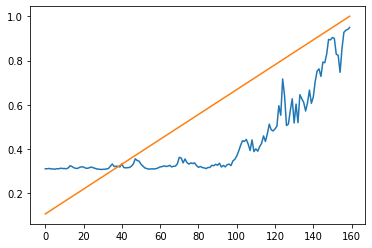

In [467]:
k = 20

t = np.arange(T[k])
plt.plot(t, ru[pre_index[k]:pre_index[k+1]])
plt.plot(t, y_train[pre_index[k]:pre_index[k+1]])

In [423]:
train_index[0].groupby('unit number').get_group(18)

,unit number,time
3581,18,1
3582,18,2
3583,18,3
3584,18,4
3585,18,5
...,...,...
3771,18,191
3772,18,192
3773,18,193
3774,18,194


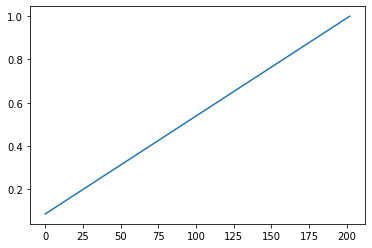

In [437]:
plt.plot(y_train[pre_index[1]:pre_index[2]])

In [468]:
T = np.array(INDEX)-19

pre_index = np.cumsum(np.array(INDEX)-19)
pre_index=np.insert(pre_index, 0, 0)
#pre_index

In [472]:
pre_test_index = np.cumsum(np.array(INDEX_test)-19)
pre_test_index = np.insert(pre_test_index, 0, 0)
pre_test = model.predict(x_test)[1]

ValueError: in user code:

    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 20, 9), found shape=(None, 20, 23)


In [471]:
from sklearn.linear_model import LinearRegression
k = 104
observ = 20

linear_reg_y = pre_test[pre_test_index[k]:pre_test_index[k+1]][-observ:]
linear_reg_x = np.arange(observ).reshape(-1,1)

reg = LinearRegression().fit(linear_reg_x, linear_reg_y)
reg.score(linear_reg_x, linear_reg_y)
A, B = reg.coef_, reg.intercept_
print((1-B)/A)
print(RUL[1].loc[k-100])

need_x = int((1-B)/A)
#plt.plot(linear_reg_y)
plt.scatter(linear_reg_x, linear_reg_y)
plt.plot((A*np.arange(need_x)+B).flatten(), 'r')
plt.show()

NameError: name 'pre_test' is not defined